In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
import csv
import unidecode
import math
import utm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def calculate_weighted_mean(data):
    data['FE_VIA'] = data['FE_VIA'].apply(lambda x: 1 if math.isnan(x) else x)
    data['FE_VIA'] = data['FE_VIA'].apply(lambda x: 1 if int(x) == 0 else x)
    data['MP'] = data['FE_VIA'] * data['DURACAO']
    data['MP_DIST'] = data['FE_VIA'] * data['DISTANCE']
    return data

folder_data = "../data/"
arq17 = "dados17_distance.csv"

data17 = pd.read_csv(folder_data + arq17, dtype={'ZONA_O': str, 'ZONA_D': str}, header=0,delimiter=",", low_memory=False) 
data17 = data17.dropna(subset=['CO_O_X'])

data17 = data17.drop(['ID_DOM', 'FE_DOM', 'VIA_BICI','TP_ESTBICI','F_FAM','FE_FAM','FAMILIA','NO_MORAF',
                      'CONDMORA','QT_BANHO','QT_EMPRE','QT_AUTO','QT_MICRO','QT_LAVALOU','QT_GEL1'], axis=1)

csv_file = folder_data + "regioes17.csv"
mydict = []
with open(csv_file, mode='r') as infile:
    reader = csv.reader(infile, delimiter=";")
    mydict = {rows[0]:rows[1] for rows in reader}

csv_file = folder_data + "zonas17.csv"
zonas_nomes = []
with open(csv_file, mode='r') as infile:
    reader = csv.reader(infile, delimiter=";")
    zonas_nomes = {rows[0]:rows[1] for rows in reader}

data17['NOME_O'] = data17['ZONA_O'].apply(lambda x: '' if pd.isnull(x) else mydict[x])
data17['NOME_D'] = data17['ZONA_D'].apply(lambda x: '' if pd.isnull(x) else mydict[x])

data17['ZONA_O'] = data17['ZONA_O'].apply(lambda x: '' if pd.isnull(x) else zonas_nomes[x])
data17['ZONA_D'] = data17['ZONA_D'].apply(lambda x: '' if pd.isnull(x) else zonas_nomes[x])

data17['NUM_TRANS'] = data17[['MODO1', 'MODO2','MODO3','MODO4']].count(axis=1)

data17 = calculate_weighted_mean(data17)

data17.head()

,Unnamed: 0,ZONA,MUNI_DOM,CO_DOM_X,CO_DOM_Y,F_DOM,DOM,CD_ENTRE,DATA,TIPO_DOM,...,OX,OY,DX,DY,DISTANCE,NOME_O,NOME_D,NUM_TRANS,MP,MP_DIST
0,0,1,36,333743,7394463,1,1,1,6092017,1,...,333743,7394463,333104,7394476,639.169735,Se,Se,1,221.32647,14146.518108
1,1,1,36,333743,7394463,0,1,1,6092017,1,...,333104,7394476,333743,7394463,639.169735,Se,Se,1,221.32647,14146.518108
2,2,1,36,333743,7394463,0,1,1,6092017,1,...,333743,7394463,327503,7392159,6652.079711,Se,Pinheiros,1,944.12435,125607.808674
3,3,1,36,333743,7394463,0,1,1,6092017,1,...,327503,7392159,329431,7395939,4243.454978,Pinheiros,Perdizes,2,1132.94922,80126.983465
4,4,1,36,333743,7394463,0,1,1,6092017,1,...,329431,7395939,333743,7394463,4557.854449,Perdizes,Se,1,755.29948,86063.627387


In [4]:
modos17 = {0:'outros',1:'metro',2:'trem',3:'metro',4:'onibus',5:'onibus',6:'onibus',7:'fretado', 8:'escolar',9:'carro-dirigindo', 10: 'carro-passageiro', 11:'taxi', 12:'taxi-nao-convencional', 13:'moto', 14:'moto-passageiro', 15:'bicicleta', 16:'pe', 17: 'outros'}
data17['MODOPRIN'] = data17['MODOPRIN'].replace(modos17)

data17['MODOPRIN'].head()

0                       pe
1                       pe
2                    metro
3                    metro
4    taxi-nao-convencional
Name: MODOPRIN, dtype: object

In [5]:
conj17 = data17[['MODOPRIN', 'FE_VIA']].groupby(['MODOPRIN']).sum().sort_values(by=['FE_VIA']).reset_index()
conj17.columns = ['MODOPRIN', 'FE_VIA']
conj17 = conj17.set_index('MODOPRIN')
conj17.head()

,FE_VIA
MODOPRIN,
moto-passageiro,96218.515611
taxi,100342.998136
outros,111716.600906
fretado,251534.512796
taxi-nao-convencional,368101.399357


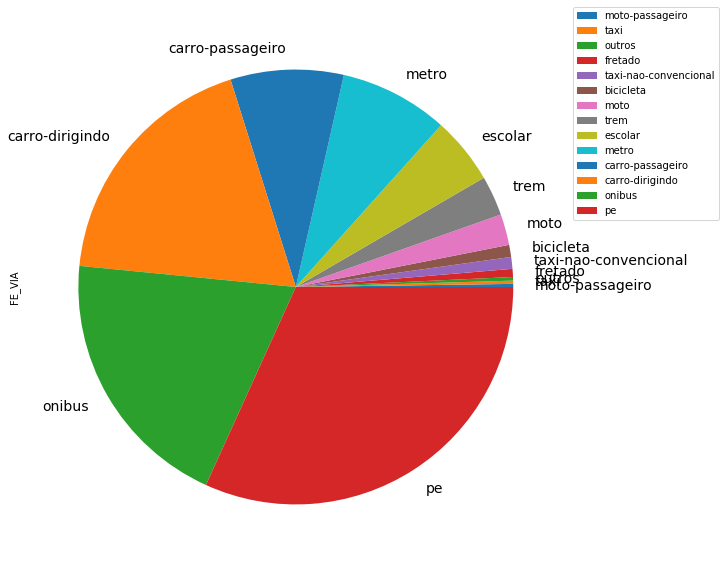

In [6]:
plt.figure(figsize=(26,10))
# plot chart
ax1 = plt.subplot(121, aspect='equal')

conj17.plot(kind='pie', y = 'FE_VIA', ax=ax1,legend = True, fontsize=14)
plt.legend(bbox_to_anchor=(1,1.025), loc="upper left")
# plot table
plt.show()

In [7]:
conj17

,FE_VIA
MODOPRIN,
moto-passageiro,9.621852e+04
taxi,1.003430e+05
outros,1.117166e+05
fretado,2.515345e+05
taxi-nao-convencional,3.681014e+05
bicicleta,3.769752e+05
moto,9.678916e+05
trem,1.244978e+06
escolar,2.093542e+06


7,8 milhões de carro 376 mil de bicicleta

In [8]:
conj17['POR'] = conj17['FE_VIA'] / conj17['FE_VIA'].sum() * 100
conj17

,FE_VIA,POR
MODOPRIN,,
moto-passageiro,9.621852e+04,0.229055
taxi,1.003430e+05,0.238874
outros,1.117166e+05,0.265950
fretado,2.515345e+05,0.598797
taxi-nao-convencional,3.681014e+05,0.876293
bicicleta,3.769752e+05,0.897418
moto,9.678916e+05,2.304138
trem,1.244978e+06,2.963763
escolar,2.093542e+06,4.983835


Mais de 20 vezes viagens de carro do que de bicicleta

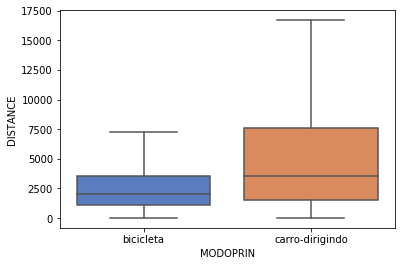

In [21]:
bicicleta = data17[data17['MODOPRIN'] == 'bicicleta']

carro = data17[data17['MODOPRIN'] == 'carro-dirigindo']

total = bicicleta.append(carro)
total.head()

sns.boxplot(x="MODOPRIN", y="DISTANCE", data=total, palette="muted", showfliers = False)



Apesar das viagens de bicicletas serem menores que as de carro, metade das viagens de carro tem distâncias iguais ou menores que 75% viagens de bicicletas